# Feature Selection and Engineering

*In which we boost, combine, split, or otherwise manipulate the features of crabs.*


### Define Constants


In [13]:
CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_CACHE_FILE = '../cache/designrcrabs.feather'
NEXT_NOTEBOOK = '../3-evaluation/evaluation.ipynb'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]


### Importing Libraries


In [14]:
from notebooks.time_for_crab.mlutils import display_df

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


### Load Data from Cache

In the [previous section](../1-models/models.ipynb), we saved the normalized training data to the cache.


In [15]:
crabs = pd.read_feather(CACHE_FILE)

display_df(crabs, show_distinct=True)
# split features from target
X_train = crabs.drop([PREDICTION_TARGET], axis=1)
y_train = crabs[PREDICTION_TARGET]


DataFrame shape: (3114, 11)
First 5 rows:
        Length  Diameter    Height    Weight  Shucked Weight  Viscera Weight  \
1698  0.500977  0.394531 -0.725586 -0.199707       -0.126953       -0.445801   
1361  0.743164  0.713867 -0.645996  0.489258        0.507812       -0.045898   
1972  0.013672 -0.025391 -0.787598 -0.706543       -0.755859       -0.750977   
960   0.163086  0.126953 -0.813965 -0.537109       -0.616211       -0.527344   
2639  0.716797  0.748047 -0.690430  0.099609       -0.041504       -0.026367   

      Shell Weight  Sex_F  Sex_I  Sex_M  Age  
1698     -0.362305  False  False   True    8  
1361      0.100586  False  False   True   12  
1972     -0.701660   True  False  False    9  
960      -0.579102  False  False   True   11  
2639      0.159180   True  False  False   15  
<class 'pandas.core.frame.DataFrame'>
Index: 3114 entries, 1698 to 645
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 

### Data Normalization

Crabs come in all shapes and sizes. Let's normalize the data to help our model make better sense of it.

![Tiny crab](https://www.popsci.com/uploads/2022/02/09/fiddler-crab.jpg?auto=webp&optimize=high&width=1440)

The book *Designing Machine Learning Systems* (Huyen, 2022) suggests normalizing to a range of [-1, 1] helps in practice.

Data normalization can help avoid data leakage based on the "form" of the data.


In [23]:
def data_normalization(df:pd.DataFrame, a:float=-1., b:float=1., df_min:pd.Series=None,  df_max:pd.Series=None) -> pd.DataFrame:
    """Normalize the DataFrame from a to b.
    
    :param df: The data.
    :param a: The minimum value.
    :param b: The maximum value.
    :param df_min: The minimum value of the data.
    :param df_max: The maximum value of the data.
    :return: The normalized data.
    """
    # scale the data to a range of [a, b]
    df_min = df.min() if df_min is None else df_min
    df_max = df.max() if df_max is None else df_max
    df = a + ((df - df_min) * (b - a)) / (df_max - df_min)
    return df


#### Show Distributions Before Normalization


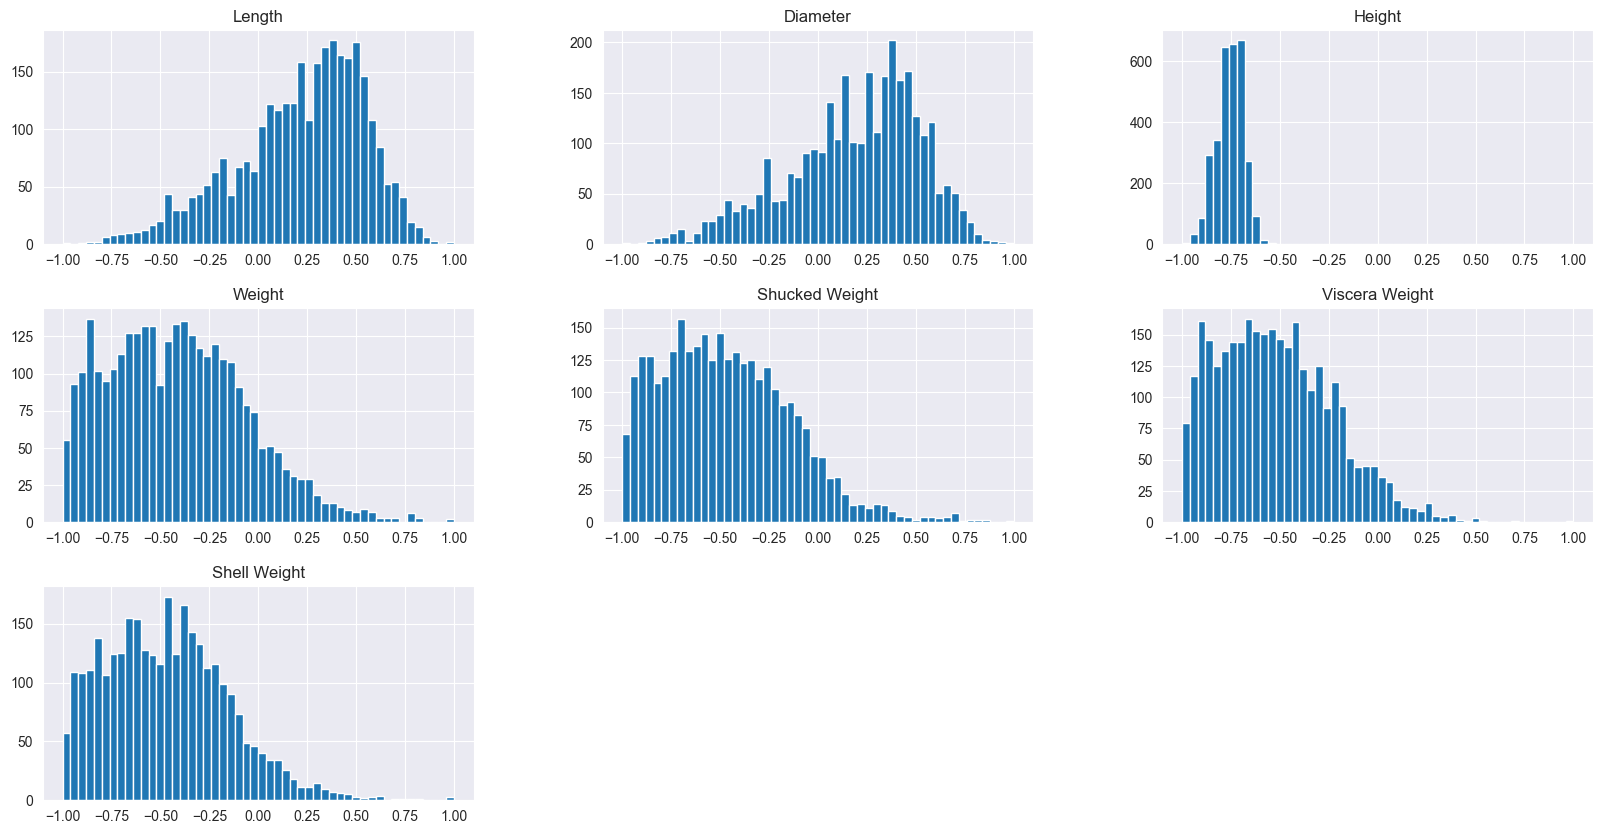

In [17]:
X_train.hist(figsize=(20, 10), bins=50)
plt.title('Before Normalization')
plt.show()


#### Normalize the Data
 
Ensure we're only normalizing using parameters from the training data to prevent data leakage.  


In [18]:

for col in X_train.select_dtypes(include=[np.number]).columns:
    X_train[col] = data_normalization(X_train[col], df_min=X_train[col].min(), df_max=X_train[col].max())
X_train.describe().transpose()[['mean','std']]


,mean,std
Length,0.213989,0.329102
Diameter,0.185913,0.337891
Height,-0.752930,0.076477
Weight,-0.412354,0.351318
Shucked Weight,-0.467285,0.330566
Viscera Weight,-0.523438,0.292236
Shell Weight,-0.467773,0.314941


#### Show Distributions After Normalization

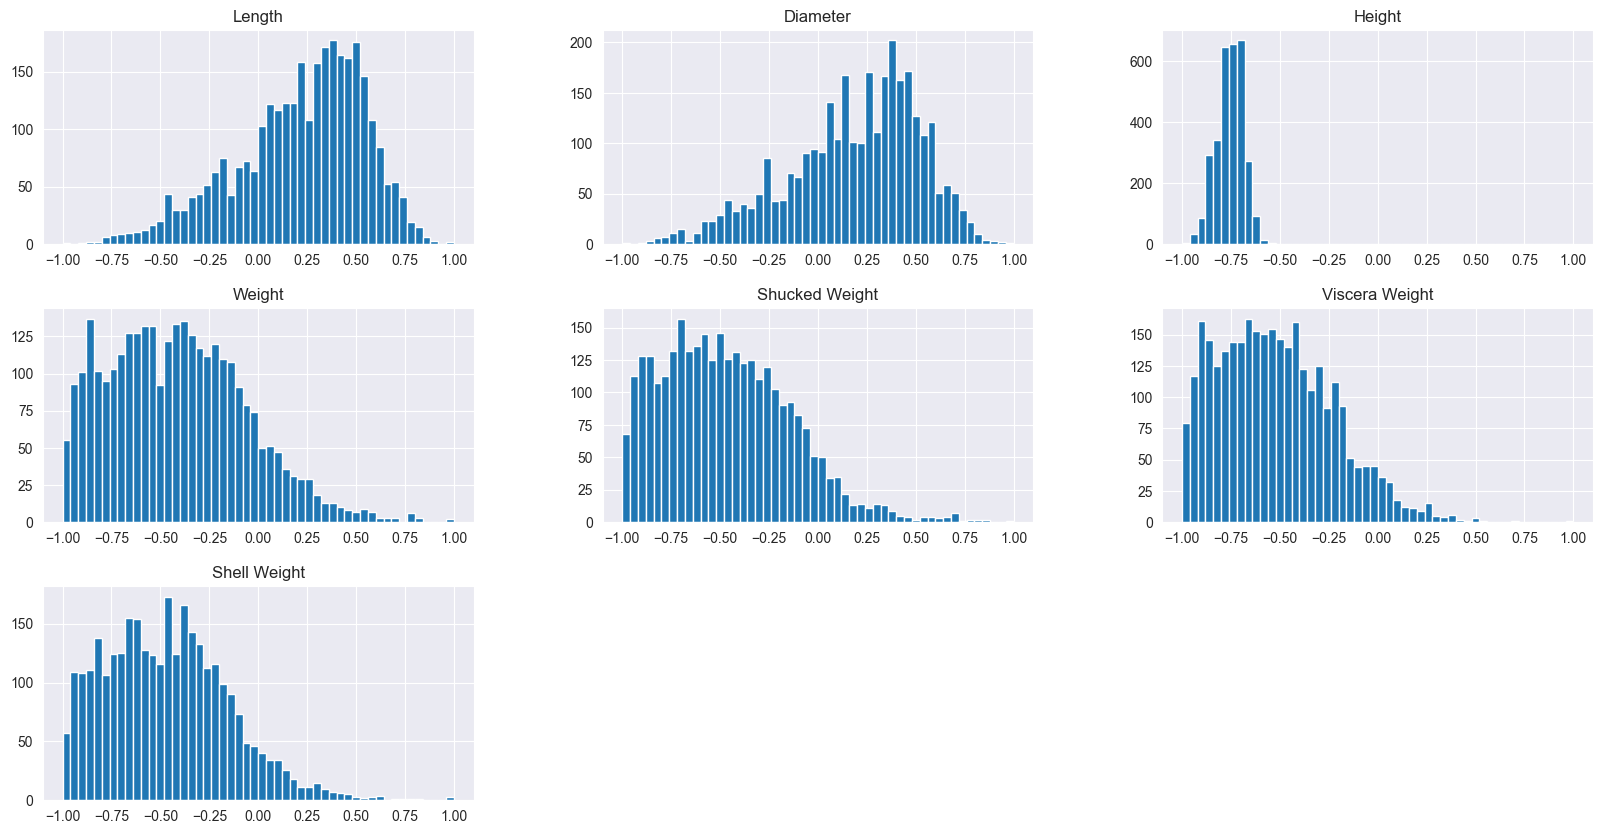

In [24]:
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)
plt.title('After Normalization')
plt.show()


### Feature Significance

Remove features with low variance. These features are likely to be less important for the model.


In [19]:
from sklearn.feature_selection import VarianceThreshold


### Data Augmentation

Crabs are complex creatures. Let's engineer some features to help our model find the best crabs for harvest.

We'll need to use domain knowledge to extract more features from our dataset's column.

![This kills the crab.](https://i.kym-cdn.com/photos/images/newsfeed/000/112/843/killcrab.jpg)

For example, we can find the edible weight of the crab by subtracting the viscera weight from the shucked weight.  
However, we need to be careful not to overfit the model by adding coliinear features.


In [20]:
def data_augmentation(df:pd.DataFrame) -> pd.DataFrame:
    """Add new features to the DataFrame.

    Driven by domain knowledge.

    :param df: The data.
    :return: The data with new features.
    """
    # add new features by combining existing features
    df['Edible Weight'] = df['Shucked Weight'] - df['Viscera Weight']
    return df


## Feature Selection

Selecting only the most important features. We'll use **Recursive Feature Elimination** (RFE).


In [21]:
# implement RFE from scratch

def rfe(X:pd.DataFrame, y:pd.Series, n_features:int) -> pd.DataFrame:
    """Select the most important features using Recursive Feature Elimination.

    :param X: The features.
    :param y: The target.
    :param n_features: The number of features to select.
    :return: The selected features.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.feature_selection import RFE

    # create the RFE model and select n features
    model = LinearRegression()
    rfe = RFE(model, n_features)
    fit = rfe.fit(X, y)

    # get the selected features
    selected = fit.support_
    return X.loc[:, selected]


### Save the Data

So we can pick this back up on the [next step](../3-evaluation/evaluation.ipynb).


In [22]:
crabs.to_feather(NEXT_CACHE_FILE)


### Onwards to Final Evaluation

See the [next section](../3-evaluation/evaluation.ipynb) for the final evaluation.
